In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
titanic_train = pd.read_csv("data/titanic/train.csv")
titanic_test = pd.read_csv("data/titanic/test.csv")
print(titanic_train.shape, titanic_test.shape)
titanic_train.head(3)

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering

### missing value

In [3]:
miss_prob = titanic_train.isna().sum() / len(titanic_train)
miss_prob = miss_prob[miss_prob != 0].sort_values(ascending = False)
miss_prob = pd.DataFrame(miss_prob, columns = ["missing ratio"])
miss_prob

,missing ratio
Cabin,0.771044
Age,0.198653
Embarked,0.002245


In [4]:
titanic_train[titanic_train.isna().any(axis = 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


#### 眾數 - 類別變數

In [5]:
# Cabin impute using 'NA'
titanic_train['Cabin'] = titanic_train['Cabin'].fillna('NA') 
titanic_test['Cabin'] = titanic_test['Cabin'].fillna('NA')

# Embarked impute using mode
titanic_train['Embarked'] = titanic_train['Embarked'].fillna(titanic_train['Embarked'].mode()[0])

#### 平均數 - 連續變數

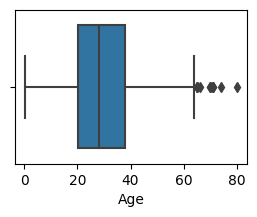

In [6]:
plt.figure(figsize = (3, 2))
sns.boxplot(x = 'Age', data = titanic_train)
plt.show()

# 年齡常態對稱
titanic_train['Age'] = titanic_train['Age'].fillna(value = titanic_train['Age'].mean())
titanic_test['Age'] = titanic_test['Age'].fillna(value = titanic_train['Age'].mean())

#### 中位數 - 連續變數

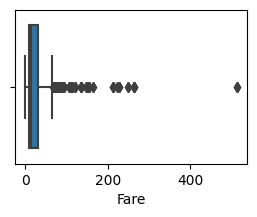

In [7]:
plt.figure(figsize = (3, 2))
sns.boxplot(x = 'Fare', data = titanic_train)
plt.show()

# 票價偏態
titanic_test['Fare'] = titanic_test['Fare'].fillna(value = titanic_train['Fare'].median())

### 離散化

#### 指定閥值切割

In [8]:
age_bins = [0, 1, 10, 65, 100]
age_labels = ['baby', 'child', 'adult', 'elderly']
titanic_train['age_bucket'] = pd.cut(x = titanic_train['Age'], bins = age_bins, labels = age_labels).astype('object')
titanic_test['age_bucket'] = pd.cut(x = titanic_test['Age'], bins = age_bins, labels = age_labels).astype('object')

#### 按分位距切割

In [9]:
pd.qcut(x = titanic_train['Age'], q = 4)
pd.qcut(x = titanic_train['Age'], q = 4, labels = age_labels)

0         baby
1      elderly
2        child
3        adult
4        adult
        ...   
886      child
887       baby
888      child
889      child
890      adult
Name: Age, Length: 891, dtype: category
Categories (4, object): ['baby' < 'child' < 'adult' < 'elderly']

### 類別變數轉換

In [10]:
titanic_train = titanic_train.drop(["PassengerId", "Name", "Ticket", 'Cabin'], axis = 1)
titanic_test = titanic_test.drop(["PassengerId", "Name", "Ticket", 'Cabin'], axis = 1)

In [11]:
cat_col = ['Pclass', 'Sex', 'Embarked', 'age_bucket']

In [12]:
titanic_train[cat_col].nunique()

Pclass        3
Sex           2
Embarked      3
age_bucket    4
dtype: int64

#### label encoding

In [13]:
from sklearn import preprocessing

LabelEncoder_dict = {}
for col in cat_col:
    encoder = preprocessing.LabelEncoder()
    titanic_train[col] = encoder.fit_transform(titanic_train[col])
    titanic_test[col] = encoder.transform(titanic_test[col])

    LabelEncoder_dict[col] = encoder

#### one hot encoding

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder_value_train = encoder.fit_transform(titanic_train[["Sex", "Embarked"]]).toarray()
encoder_value_test = encoder.transform(titanic_test[["Sex", "Embarked"]]).toarray()

new_col_name = encoder.get_feature_names_out()

titanic_train[new_col_name] = encoder_value_train.astype(int)
titanic_test[new_col_name] = encoder_value_test.astype(int)
titanic_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age_bucket,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,0,2,1,22.000000,1,0,7.2500,2,0,0,1,0,0,1
1,1,0,0,38.000000,1,0,71.2833,0,0,1,0,1,0,0
2,1,2,0,26.000000,0,0,7.9250,2,0,1,0,0,0,1
3,1,0,0,35.000000,1,0,53.1000,2,0,1,0,0,0,1
4,0,2,1,35.000000,0,0,8.0500,2,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,1,27.000000,0,0,13.0000,2,0,0,1,0,0,1
887,1,0,0,19.000000,0,0,30.0000,2,0,1,0,0,0,1
888,0,2,0,29.699118,1,2,23.4500,2,0,1,0,0,0,1
889,1,0,1,26.000000,0,0,30.0000,0,0,0,1,1,0,0


In [15]:
one_hot_df = titanic_train[["Sex", "Embarked"]].astype("category")
pd.get_dummies(one_hot_df)

,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,0,1
888,1,0,0,0,1
889,0,1,1,0,0


#### Target encoding

In [16]:
from category_encoders import TargetEncoder

TargetEncoder_train = titanic_train[["age_bucket", "Embarked"]].astype("category")
TargetEncoder_test = titanic_test[["age_bucket", "Embarked"]].astype("category")

encoder = TargetEncoder()
titanic_train[["Target_age_bucket", "Target_Embarked"]] = encoder.fit_transform(TargetEncoder_train, titanic_train["Survived"])
titanic_test[["LeaveOneOut_age_bucket", "LeaveOneOut_Embarked"]] = encoder.transform(TargetEncoder_test)

c:\Users\tzuli\Documents\python\.venv\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\tzuli\Documents\python\.venv\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


#### Leave One Out Encoding

In [17]:
from category_encoders import LeaveOneOutEncoder

LeaveOneOutEncoder_train = titanic_train[["age_bucket", "Embarked"]].astype("category")
LeaveOneOutEncoder_test = titanic_test[["age_bucket", "Embarked"]].astype("category")

encoder = LeaveOneOutEncoder()
titanic_train[["LeaveOneOut_age_bucket", "LeaveOneOut_Embarked"]] = encoder.fit_transform(LeaveOneOutEncoder_train, titanic_train["Survived"])
titanic_test[["LeaveOneOut_age_bucket", "LeaveOneOut_Embarked"]] = encoder.transform(LeaveOneOutEncoder_test)

### Outlier

In [18]:
num_col = ['Age', 'SibSp', 'Parch', 'Fare']

#### 四分位數

In [19]:
quantile_col = ['quantile_Age', 'quantile_SibSp', 'quantile_Parch', 'quantile_Fare']
titanic_train[quantile_col] = titanic_train[num_col]

for col in num_col:
    q1 = titanic_train[col].quantile(0.25)
    q3 = titanic_train[col].quantile(0.75)
    iqr = q3 - q1

    low = q1 - (1.5 * iqr)
    high = q3 + (1.5 * iqr)

    low_index = titanic_train[col][titanic_train[col] < low].index
    high_index = titanic_train[col][titanic_train[col] > high].index

    titanic_train.loc[low_index, f"quantile_{col}"] = low
    titanic_train.loc[high_index, f"quantile_{col}"] = high


    low_index_test = titanic_test[col][titanic_test[col] < low].index
    high_index_test = titanic_test[col][titanic_test[col] > high].index

    titanic_test.loc[low_index_test, f"quantile_{col}"] = low
    titanic_test.loc[high_index_test, f"quantile_{col}"] = high
    
    print(f"{col}: {low} ~ {high}")

Age: 2.5 ~ 54.5
SibSp: -1.5 ~ 2.5
Parch: 0.0 ~ 0.0
Fare: -26.724 ~ 65.6344


#### z-score

In [20]:
Zscore_col = ['Zscore_Age', 'Zscore_SibSp', 'Zscore_Parch', 'Zscore_Fare']
titanic_train[Zscore_col] = titanic_train[num_col]

for col in num_col:
    low = titanic_train[col].mean() - (3 * titanic_train[col].std())
    high = titanic_train[col].mean() + (3 * titanic_train[col].std())

    low_index = titanic_train[col][titanic_train[col] < low].index
    high_index = titanic_train[col][titanic_train[col] > high].index

    titanic_train.loc[low_index, f"Zscore_{col}"] = low
    titanic_train.loc[high_index, f"Zscore_{col}"] = high


    low_index_test = titanic_test[col][titanic_test[col] < low].index
    high_index_test = titanic_test[col][titanic_test[col] > high].index

    titanic_test.loc[low_index_test, f"Zscore_{col}"] = low
    titanic_test.loc[high_index_test, f"Zscore_{col}"] = high
    
    print(f"{col}: {low} ~ {high}")

Age: -9.306928030949827 ~ 68.70516332506747
SibSp: -2.7852224405391057 ~ 3.831238153221485
Parch: -2.0365779484627966 ~ 2.799765378316893
Fare: -116.87607782296804 ~ 181.2844937601173


### 偏態

In [21]:
from scipy.stats import skew

skewness = titanic_train[quantile_col].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

,Feature,Skew
0,quantile_SibSp,1.618424
1,quantile_Fare,1.080356


In [22]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')
titanic_train[skewness["Feature"]] = pt.fit_transform(titanic_train[skewness["Feature"]])
titanic_test[skewness["Feature"]] = pt.transform(titanic_test[skewness["Feature"]])

In [23]:
from scipy.stats import skew

skewness = titanic_train[quantile_col].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

,Feature,Skew
0,quantile_SibSp,0.796686


#### Feature scaling

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(titanic_train[quantile_col])

array([[0.375     , 0.88608281, 0.        , 0.45945589],
       [0.68269231, 0.88608281, 0.        , 1.        ],
       [0.45192308, 0.        , 0.        , 0.47816789],
       ...,
       [0.52305995, 0.88608281, 0.        , 0.72897848],
       [0.45192308, 0.        , 0.        , 0.7911371 ],
       [0.56730769, 0.        , 0.        , 0.47344474]])

In [25]:
from sklearn.preprocessing import StandardScaler

normal_col = ['quantile_Age', 'quantile_Parch', 'quantile_Fare']
scaler = StandardScaler()
titanic_train[normal_col] = scaler.fit_transform(titanic_train[normal_col])
titanic_test[normal_col] = scaler.transform(titanic_test[normal_col])

In [26]:
from sklearn.preprocessing import RobustScaler

skew_col = ["quantile_SibSp"]
scaler = RobustScaler()
titanic_train[skew_col] = scaler.fit_transform(titanic_train[skew_col])
titanic_test[skew_col] = scaler.transform(titanic_test[skew_col])

## Feature Selection

### Constant feature

In [27]:
unique_counts = titanic_train.nunique()
unique_counts[unique_counts == 1]

quantile_Parch    1
dtype: int64

### Qusi-constant feature

In [28]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold = 0.05)
selector.fit(titanic_train[quantile_col])
selector.get_support()
drop_feats = [feat for feat, keep in zip(quantile_col, selector.get_support()) if not keep]

titanic_train = titanic_train.drop(drop_feats, axis = 1)
titanic_test = titanic_test.drop(drop_feats, axis = 1)

### 風向、季節、時間等週期性變數轉換 - Cyclical features encoding

In [29]:
paper = pd.read_csv("data/paper.csv", parse_dates = ["time"])

In [30]:
import numpy as np

paper["hour_sin"] = np.sin(2 * np.pi * paper["time"].dt.hour / paper["time"].dt.hour.max())
paper["hour_cos"] = np.cos(2 * np.pi * paper["time"].dt.hour / paper["time"].dt.hour.max())

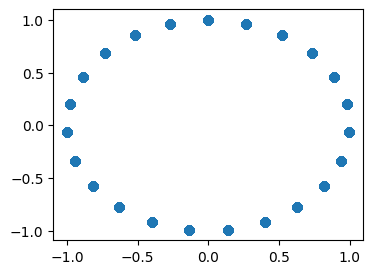

In [31]:
plt.figure(figsize = (4, 3))
plt.scatter(x = paper["hour_sin"], y = paper["hour_cos"])
plt.show()

### 經位度變數轉換

In [40]:
location = pd.read_csv("data/world_country_and_usa_states_latitude_and_longitude_values.csv")

#### Polar coordinates

In [41]:
# 直角坐標 to 極座標
r = ((location["longitude"] ** 2) + (location["latitude"] ** 2)) ** (1 / 2)
theta = np.arctan2(location["latitude"], location["longitude"])

In [46]:
# 極座標 to 直角坐標
# longitude = r * np.cos(theta)
# latitude = r * np.sin(theta)

#### Rotational Cartesian coordinates
通過旋轉座標，將為樹類型的模型提供更多空間信息。與正常的x、y坐標相比，有助於在不同的感知（視角）下可視化坐標。

In [47]:
rot_45_x = (0.707 * location['longitude']) + (0.707 * location['latitude'])
rot_45_y = (0.707 * location['latitude']) + (0.707 * location['longitude'])
rot_30_x = (0.866 * location['longitude']) + (0.5 * location['latitude'])
rot_30_y = (0.866 * location['latitude']) + (0.5 * location['longitude'])

#### Haversine distance

#### Manhattan distance